In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
model = tf.keras.models.load_model('../data/saved_model/my_model')
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [3]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [4]:
characters = open("./test.txt", "r").readlines()
characters_1 = []
for i in characters:
    a = i[0]
    characters_1.append(a)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters_1), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [6]:
max_len = 21
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


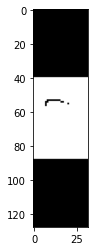

1/1 [==============================] - 1s 1s/step


['.']

In [14]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# image = tf.keras.utils.load_img("../data/words/a02/a02-000/a02-000-00-08.png")
image = tf.keras.utils.load_img("./download-this-canvas.png")
image = distortion_free_resize(image, (128,32))[:,:,:1]
# image = tf.image.rot90(image)
plt.imshow(image,cmap="gray")
plt.show()
image = image/255
image = np.expand_dims(image, axis=0)

image = np.vstack([image])
# image = np.array([image,image,image])
result = prediction_model.predict(image,batch_size=1)
pred_texts = decode_batch_predictions(result)
pred_texts